<h1><center>iMet Collection 2019 - FGVC6</center></h1>
<h2><center>Recognize artwork attributes from The Metropolitan Museum of Art</center></h2>
![](https://raw.githubusercontent.com/visipedia/imet-fgvcx/master/assets/banner.png)

### Dependencies

In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/train.csv')
labels = pd.read_csv('../input/labels.csv')
test = pd.read_csv('../input/sample_submission.csv')

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Top 30 most frequent attributes
- First, let's see between the 1103 attributes which are the most frequent ones.

Number of unique attributes:  1103


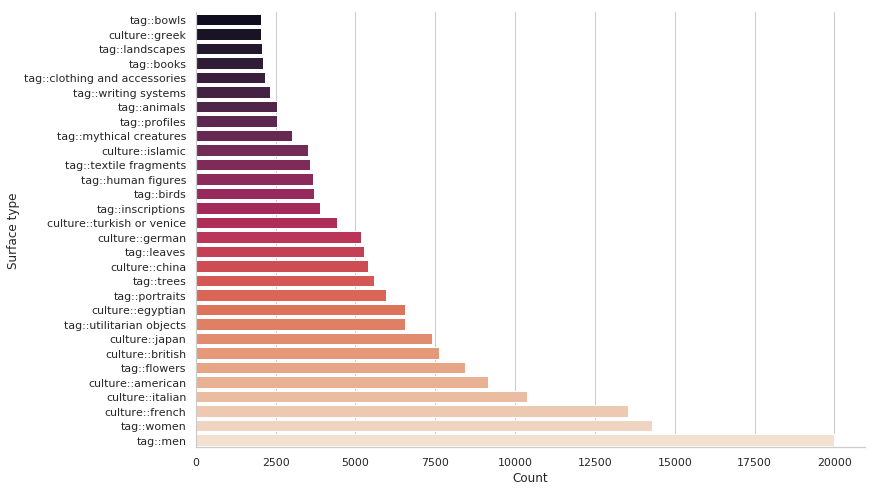

In [3]:
attribute_ids = train['attribute_ids'].values
attributes = []
for item_attributes in [x.split(' ') for x in attribute_ids]:
    for attribute in item_attributes:
        attributes.append(int(attribute))
        
att_pd = pd.DataFrame(attributes, columns=['attribute_id'])
att_pd = att_pd.merge(labels)
top30 = att_pd['attribute_name'].value_counts()[:30].to_frame()
N_unique_att = att_pd['attribute_id'].nunique()
print('Number of unique attributes: ', N_unique_att)
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(y=top30.index, x="attribute_name", data=top30, palette="rocket", order=reversed(top30.index))
ax.set_ylabel("Surface type")
ax.set_xlabel("Count")
sns.despine()
plt.show()

Number of attributes groups:  2


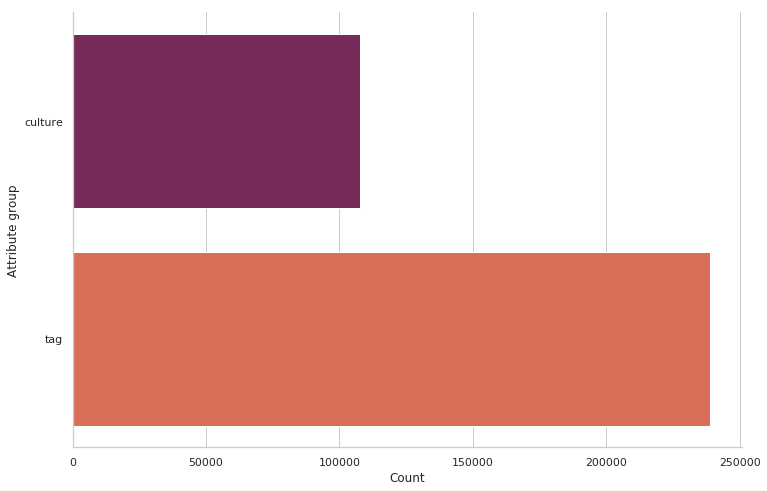

In [4]:
att_pd['tag'] = att_pd['attribute_name'].apply(lambda x:x.split('::')[0])
gp_att = att_pd.groupby('tag').count()

print('Number of attributes groups: ', gp_att.shape[0])
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(y=gp_att.index, x="attribute_name", data=gp_att, palette="rocket")
ax.set_ylabel("Attribute group")
ax.set_xlabel("Count")
sns.despine()
plt.show()

### Number of tags per item
- We saw on the training set that some of the items have more than one attribute tag, let's see the attribute tag distribution.

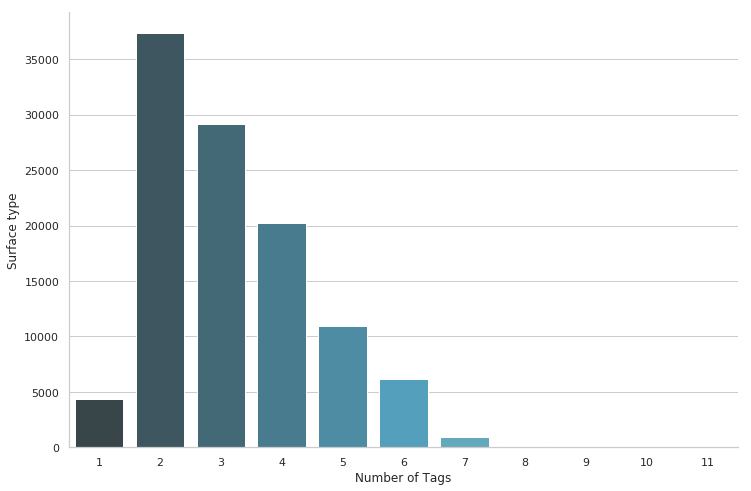

In [5]:
train['Number of Tags'] = train['attribute_ids'].apply(lambda x: len(x.split(' ')))
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x="Number of Tags", data=train, palette="GnBu_d")
ax.set_ylabel("Surface type")
sns.despine()
plt.show()

### Now let's see some of the items

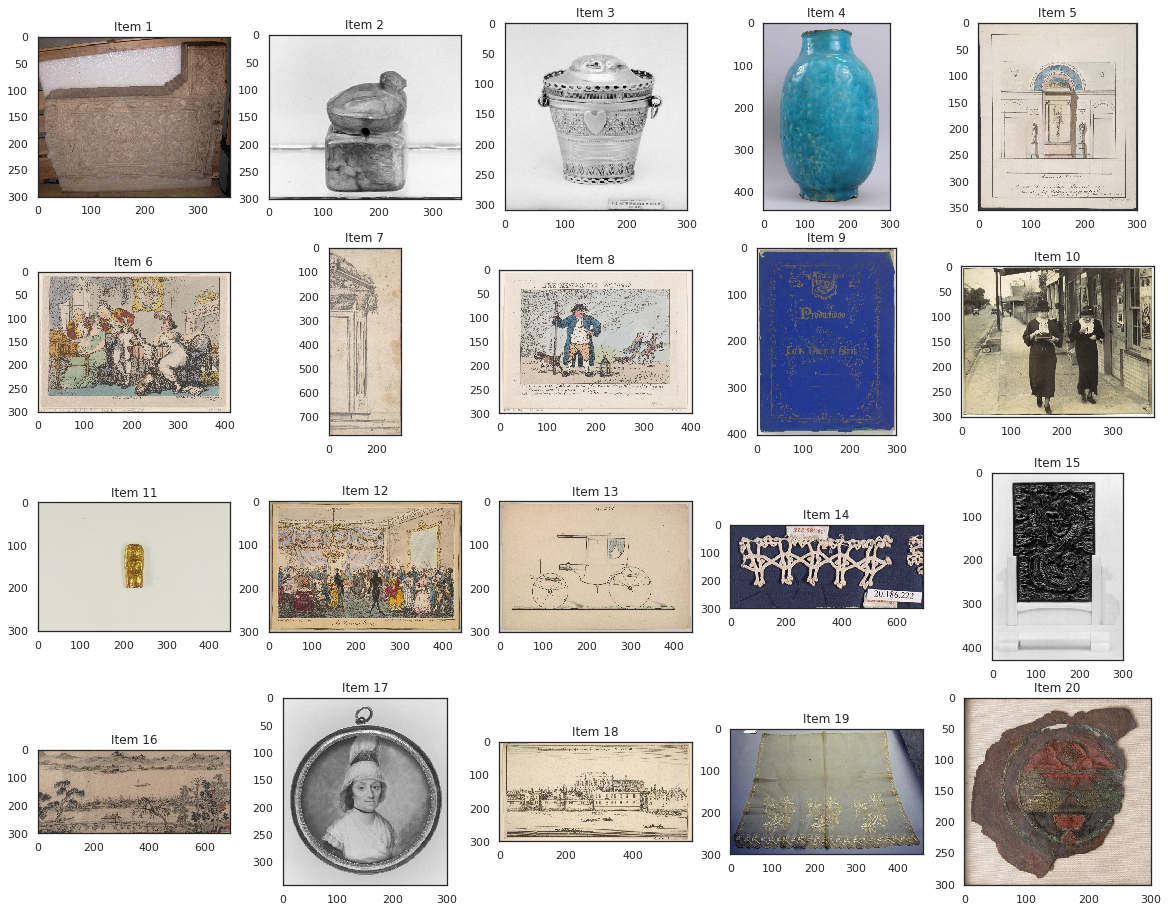

In [6]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20,20])
for img_name in os.listdir("../input/train/")[:20]:
    img = cv2.imread("../input/train/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Item %s" % count)
    count += 1
    
plt.show()

In [7]:
train["id"] = train["id"].apply(lambda x:x+".png")
test["id"] = test["id"].apply(lambda x:x+".png")

### Model

In [8]:
# Model parameters
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.0001
HEIGHT = 64
WIDTH = 64
CANAL = 3
N_CLASSES = N_unique_att
classes = list(map(str, range(N_CLASSES)))

In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', input_shape=(HEIGHT, WIDTH, CANAL)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(4,4),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(4,4),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation = "softmax"))
model.summary()

optimizer = optimizers.adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_2 (Activat

In [10]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/test",    
        x_col="id",
        target_size = (HEIGHT, WIDTH),
        batch_size = 1,
        shuffle = False,
        class_mode = None)

Found 3460 images belonging to 1103 classes.
Found 864 images belonging to 1103 classes.
Found 7443 images.


In [11]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=100,
                    validation_data=valid_generator,
                    validation_steps=50,
                    epochs=EPOCHS,
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 87s - loss: 6.0638 - acc: 0.0858 - val_loss: 5.2427 - val_acc: 0.1551
Epoch 2/50
 - 74s - loss: 4.7312 - acc: 0.1689 - val_loss: 4.6709 - val_acc: 0.1799
Epoch 3/50
 - 72s - loss: 4.2424 - acc: 0.2013 - val_loss: 4.5047 - val_acc: 0.1951
Epoch 4/50
 - 74s - loss: 4.0169 - acc: 0.2186 - val_loss: 4.4479 - val_acc: 0.1906
Epoch 5/50
 - 74s - loss: 3.7899 - acc: 0.2426 - val_loss: 4.3125 - val_acc: 0.2053
Epoch 6/50
 - 76s - loss: 3.6314 - acc: 0.2563 - val_loss: 4.3272 - val_acc: 0.2037
Epoch 7/50
 - 71s - loss: 3.4944 - acc: 0.2873 - val_loss: 4.2120 - val_acc: 0.2310
Epoch 8/50
 - 73s - loss: 3.3531 - acc: 0.2968 - val_loss: 4.1686 - val_acc: 0.2401
Epoch 9/50
 - 72s - loss: 3.2298 - acc: 0.3149 - val_loss: 4.1623 - val_acc: 0.2440
Epoch 10/50
 - 75s - loss: 3.1012 - acc: 0.3361 - val_loss: 4.1134 - val_acc: 0.2396
Epoch 11/50
 - 75s - loss: 3.0062 - acc: 0.3439 - val_loss: 4.1488 - val_acc: 0.2398
Epoch 12/50
 - 77s - loss:

### Model graph loss

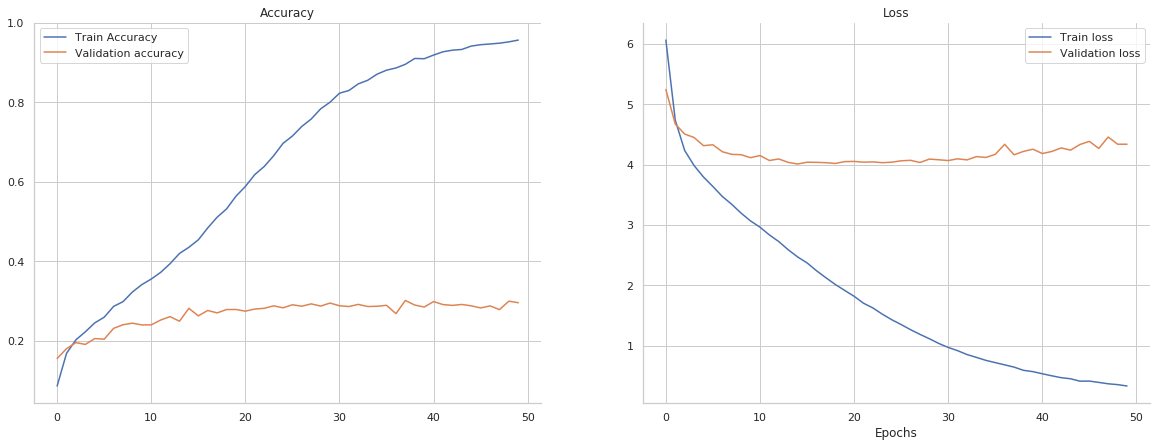

In [12]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

ax1.plot(history.history['acc'], label='Train Accuracy')
ax1.plot(history.history['val_acc'], label='Validation accuracy')
ax1.legend(loc='best')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], label='Train loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('Loss')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Apply model to test set and output predictions

In [13]:
test_generator.reset()
n_steps = len(test_generator.filenames)
predictions = model.predict_generator(test_generator, steps = n_steps)

In [14]:
predicted_class=np.argmax(predictions,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class]

In [15]:
filenames=test_generator.filenames
results=pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,1020
1,100fbe75ed8fd887,1039
2,101b627524a04f19,813
3,10234480c41284c6,931
4,1023b0e2636dcea8,663
5,1039cd6cf85845c,1092
6,103a5b3f83fbe88,1046
7,10413aaae8d6a9a2,1059
8,10423822b93a65ab,1059
9,1052bf702cb099f7,813


#### As you can see this kind of approach outputs only one attribute tag, but it's possible that an item has multiple tags, so this must be improved.